In [1]:

%load_ext autoreload
%autoreload 2
import pandas as  pd
import numpy as np
from sklearn.metrics import precision_score
from hydra import compose, initialize
from hydra.utils import instantiate
import shap
import plotly.express as px


from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.calibration import CalibrationDisplay


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
from ProcessData.dataset import Dataset
from ProcessData.data_splitter import data_splitter
from ProcessData.data_window import add_normalized_cols

In [3]:
initialize(config_path="../conf/")
cfg = compose(config_name='config.yaml')


The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1


In [4]:
pipeline = instantiate(cfg.data_pipeline)

In [5]:
df = pd.read_csv('../data/Unprocessed_Data.csv')
df = pipeline.apply(df.copy())

In [6]:
window = 3
model_features = []
#model_features = [ 'rsi', 'mfi', 'regrs', 'cci']
model_features += ['rsi_norm_' + str(i) for i in range(1,window)]
model_features += ['mfi_norm_' + str(i) for i in range(1,window)]
#model_features += ['williams_' + str(i) for i in range(1,window)]
model_features += ['tv_norm_' + str(i) for i in range(1,window)]
model_features += ['regrs_norm_' + str(i) for i in range(1,window)]
model_features += ['sma_norm_' + str(i) for i in range(1,window)]
model_features += ['cci_norm_' + str(i) for i in range(1,window)]
len(model_features)

12

In [7]:
dataset = Dataset(data = df, data_splitter = data_splitter)
clf = HistGradientBoostingClassifier( l2_regularization = 20, learning_rate=0.5, max_iter=20, max_leaf_nodes  = 20, max_depth=5, random_state=5).fit(dataset.X_train[model_features], dataset.y_train, sample_weight = dataset.X_train['sample_weight'])

Splitted data


In [8]:
HistGradientBoostingClassifier(**cfg.model.model_params)

HistGradientBoostingClassifier(l2_regularization=20, learning_rate=0.5,
                               max_bins=25, max_depth=5, max_iter=5,
                               max_leaf_nodes=66, min_samples_leaf=1,
                               random_state=1)

In [9]:
roc_test = roc_auc_score(dataset.y_train, clf.predict_proba(dataset.X_train[model_features]).T[1])
precision_test = precision_score(dataset.y_train, clf.predict(dataset.X_train[model_features]))

print(f'roc_test: {roc_test}')
print(f'precision_test: {precision_test}')

roc_test: 0.9257358662695538
precision_test: 0.8521303258145363


In [10]:
roc_test = roc_auc_score(dataset.y_test, clf.predict_proba(dataset.X_test[model_features]).T[1])
precision_test = precision_score(dataset.y_test, clf.predict(dataset.X_test[model_features]))

print(f'roc_test: {roc_test}')
print(f'precision_test: {precision_test}')

roc_test: 0.6233365272011072
precision_test: 0.616822429906542


In [11]:
roc_test = roc_auc_score(dataset.y_oot, clf.predict_proba(dataset.X_oot[model_features]).T[1])
precision_test = precision_score(dataset.y_oot, clf.predict(dataset.X_oot[model_features]))

print(f'roc_oot: {roc_test}')
print(f'precision_oot: {precision_test}')

roc_oot: 0.6089335180055402
precision_oot: 0.5476190476190477


In [12]:
# explainer = shap.TreeExplainer(clf, dataset.X_test[model_features])
# shap_values = explainer(dataset.X_train[model_features], check_additivity =  False)
# prediction = clf.predict_proba(dataset.X_train[model_features])
# shap.plots.beeswarm(shap_values, max_display=70)

<Axes: >

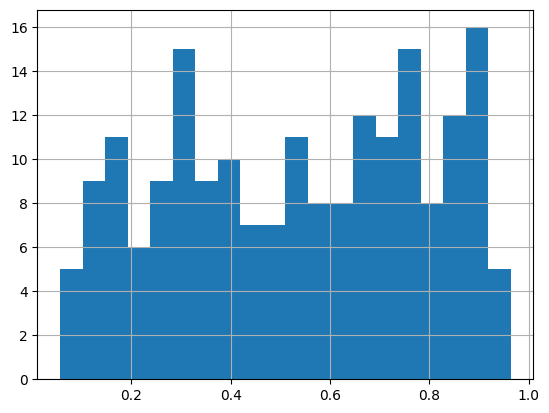

In [13]:
pd.Series(clf.predict_proba(dataset.X_test[model_features]).T[1]).hist(bins = 20)

In [14]:

pred = [1 if d > 0.8 else 0 for d in clf.predict_proba(dataset.X_oot[model_features]).T[1]]

In [15]:

from datetime import datetime
def calculate_time_difference(date_str1, date_str2):
    date_format = '%d.%m.%Y %H:%M:%S'
    dates = dataset.X_oot['Datum'].apply(lambda x: datetime.strptime(x, date_format))
    date1 = min(dates)
    date2 = max(dates)
    
    time_difference = date2 - date1
    
    days = time_difference.days
    
    print(date1)
    print(date2)
    return {'days': days,}


In [16]:
dataset.X_oot['diff'] = dataset.X_oot['next_close_price'] - dataset.X_oot['close_price']
dataset.X_oot['pred'] = pred
print( sum(dataset.X_oot['diff'][dataset.X_oot['pred'] ==1]) - sum(pred)*0.00006)
final_pred =dataset.X_oot['diff'][dataset.X_oot['pred'] ==1] -0.00006
px.line(final_pred.cumsum(axis = 0))

-0.02350000000000002


In [17]:
dataset.X_oot.iloc[1]

index                               968
Datum               28.09.2021 08:50:07
close_price                       1.168
open_price                         1.17
high_price                         1.17
low_price                         1.168
rsi1                               36.7
mfi1                          21.477135
tv1                                 1.0
sma1                           1.176286
williams1                        -100.0
regrs1                         0.794382
cci1                        -133.802817
rsi2                               38.8
mfi2                          21.456295
tv2                                 1.0
sma2                           1.177429
williams2                        -100.0
regrs2                           0.7829
cci2                        -108.856089
rsi3                               43.5
mfi3                          21.435496
tv3                                 1.0
sma3                           1.178571
williams3                    -77.777778


In [18]:
dataset.X_oot.iloc[dataset.X_oot.shape[0]-1]

index                              1137
Datum               20.01.2022 02:18:42
close_price                       1.136
open_price                        1.134
high_price                        1.136
low_price                         1.134
rsi1                               48.9
mfi1                           50.05848
tv1                                 1.0
sma1                               1.14
williams1                         -75.0
regrs1                         0.372308
cci1                         -10.638298
rsi2                               42.6
mfi2                           50.05848
tv2                                 1.0
sma2                               1.14
williams2                        -100.0
regrs2                         0.150769
cci2                         -53.475936
rsi3                               45.2
mfi3                          57.157178
tv3                                 1.0
sma3                           1.140143
williams3                         -87.5


In [19]:
max(dataset.X_train['Datum'])

'31.12.2020 16:42:30'

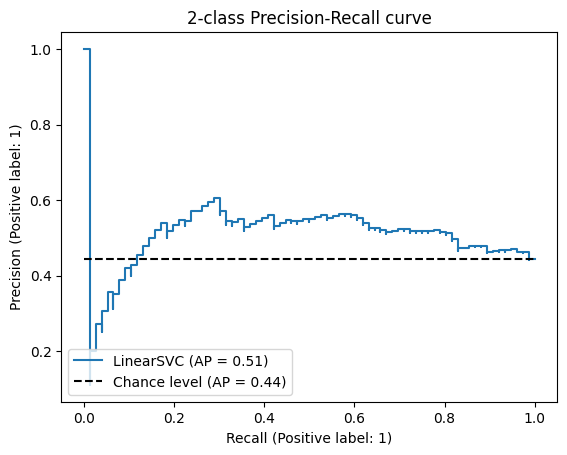

In [20]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    clf, dataset.X_oot[model_features], dataset.y_oot, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

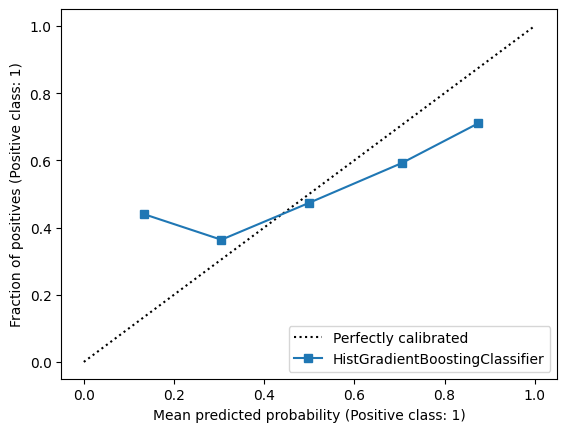

In [21]:
disp = CalibrationDisplay.from_estimator(clf, dataset.X_test[model_features], dataset.y_test)

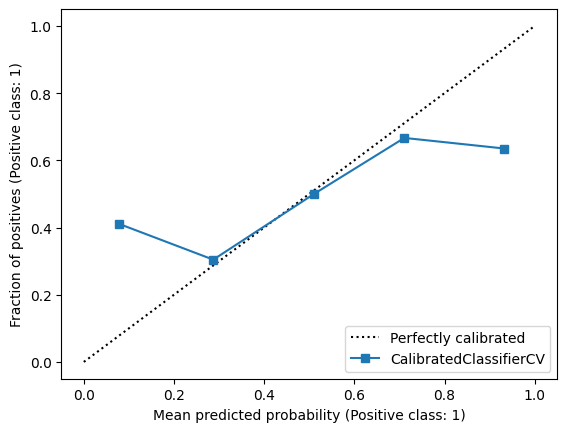

In [22]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_clf = CalibratedClassifierCV(clf, cv='prefit')
calibrated_clf.fit(dataset.X_train[model_features], dataset.y_train)
disp = CalibrationDisplay.from_estimator(calibrated_clf, dataset.X_test[model_features], dataset.y_test)

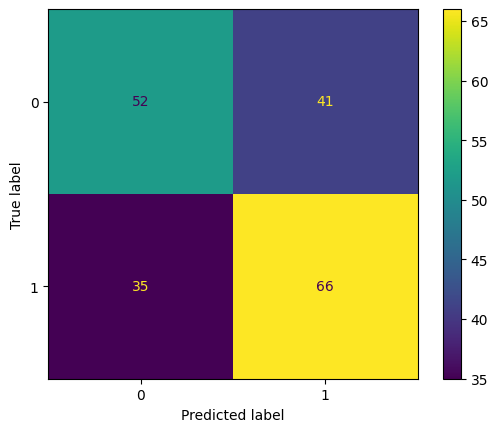

In [23]:
cm = confusion_matrix(dataset.y_test, calibrated_clf.predict(dataset.X_test[model_features]))
ConfusionMatrixDisplay(cm).plot()

In [24]:
pred = [1 if d > 0.95 else 0 for d in calibrated_clf.predict_proba(dataset.X_oot[model_features]).T[1]]

<Axes: >

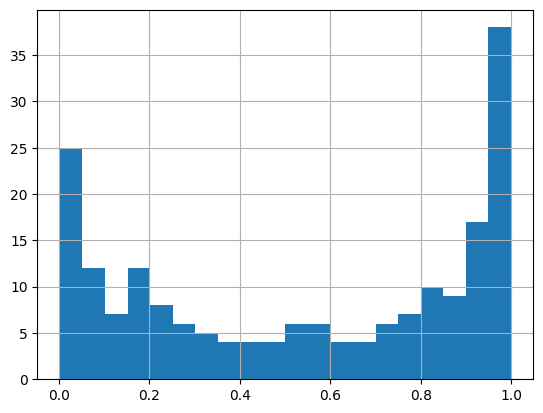

In [25]:
pd.Series(calibrated_clf.predict_proba(dataset.X_test[model_features]).T[1]).hist(bins = 20)

In [26]:
from sklearn.calibration import calibration_curve

In [27]:
from sklearn.metrics import log_loss

In [28]:
calibration_curve(dataset.y_test, calibrated_clf.predict_proba(dataset.X_test[model_features]).T[1])

(array([0.41071429, 0.30434783, 0.5       , 0.66666667, 0.63513514]),
 array([0.07836502, 0.28712943, 0.51054259, 0.71088097, 0.93269084]))

In [29]:
log_loss(dataset.y_test, clf.predict_proba(dataset.X_test[model_features]).T[1])

0.7435949950389227

In [30]:
test_DF = dataset.X_train[model_features].iloc[0]

In [31]:
test_DF

rsi_norm_1       0.000000
rsi_norm_2       3.165800
mfi_norm_1       0.000000
mfi_norm_2       6.051954
tv_norm_1        0.000000
tv_norm_2        0.000000
regrs_norm_1     0.000000
regrs_norm_2     0.077301
sma_norm_1       0.002281
sma_norm_2       0.001283
cci_norm_1       0.000000
cci_norm_2      17.611594
Name: 786, dtype: float64

In [32]:
test_DF.to_json("testdf.json")

In [33]:
 pd.read_json("testdf.json", orient = 'index').T

,rsi_norm_1,rsi_norm_2,mfi_norm_1,mfi_norm_2,tv_norm_1,tv_norm_2,regrs_norm_1,regrs_norm_2,sma_norm_1,sma_norm_2,cci_norm_1,cci_norm_2
0,0.0,3.1658,0.0,6.051954,0.0,0.0,0.0,0.077301,0.002281,0.001283,0.0,17.611594


In [34]:
import json
with open('testdf.json', 'r') as file:
            input_data = json.load(file)

In [35]:
input_data

{'rsi_norm_1': 0.0,
 'rsi_norm_2': 3.1658002736,
 'mfi_norm_1': 0.0,
 'mfi_norm_2': 6.0519536155,
 'tv_norm_1': 0.0,
 'tv_norm_2': 0.0,
 'regrs_norm_1': 0.0,
 'regrs_norm_2': 0.0773012646,
 'sma_norm_1': 0.0022806365,
 'sma_norm_2': 0.0012825461,
 'cci_norm_1': 0.0,
 'cci_norm_2': 17.611593961}

In [36]:
pd.DataFrame.from_dict(input_data, orient="index").T

,rsi_norm_1,rsi_norm_2,mfi_norm_1,mfi_norm_2,tv_norm_1,tv_norm_2,regrs_norm_1,regrs_norm_2,sma_norm_1,sma_norm_2,cci_norm_1,cci_norm_2
0,0.0,3.1658,0.0,6.051954,0.0,0.0,0.0,0.077301,0.002281,0.001283,0.0,17.611594


In [37]:
import joblib


joblib.dump(clf, 'model.pkl')

['model.pkl']

In [38]:
len(clf.feature_names_in_)

12

In [39]:
from Model.SklearnPipeline import CustomPipeline
import pandas as pd

In [40]:
t = CustomPipeline(["rsi", "mfi", "regrs", "cci", "sma", "tv"], window = 4)

In [41]:
testdf = pd.read_csv("../../Data_Collect_32/data/Unprocessed_Data.csv")
testdf = testdf.dropna()
testdf['Datum'] = pd.to_datetime(testdf['Datum'], dayfirst=True)

In [42]:
max(testdf['Datum'])

Timestamp('2022-01-20 19:35:04')

In [43]:
testdf.shape

(1139, 33)

In [44]:
def create_label(df: pd.DataFrame) -> pd.DataFrame:
    _df = df.copy()
    diff = _df['next_close_price'] -  _df['close_price']
    _df['diff'] = diff * 1000
    _df['sample_weight'] = [2.1 if ((x >= -4.0 )| (x < 3.0)) else 1 for x in _df['diff']]
    _df['y'] = (diff >= 0.001).astype(int)
    return _df


def shift_close(df: pd.DataFrame) -> pd.DataFrame:
    _df = df.copy()
    _df['next_close_price'] = df['close_price'].shift(-1)
    _df['next_open_price'] = df['open_price'].shift(-1)
    return _df

ydf = create_label(shift_close(testdf))

In [45]:
testdf.drop(columns="Datum")

,close_price,open_price,high_price,low_price,rsi1,mfi1,tv1,sma1,williams1,regrs1,...,williams3,regrs3,cci3,rsi4,mfi4,tv4,sma4,williams4,regrs4,cci4
0,1.086,1.084,1.086,1.084,54.7,64.351811,1.0,1.080857,-0.000000,0.169761,...,-0.000000,0.150430,60.736490,52.8,50.061761,1.0,1.079429,-0.000000,0.025743,14.184397
1,1.088,1.086,1.088,1.086,57.1,64.370651,1.0,1.081429,-0.000000,0.299376,...,-33.333333,0.150430,6.391347,55.4,57.226020,1.0,1.079857,-0.000000,0.150430,60.736490
2,1.084,1.086,1.086,1.084,51.2,57.214566,1.0,1.081571,-28.571429,0.401921,...,-0.000000,0.169761,70.846075,49.4,57.210881,1.0,1.080143,-33.333333,0.150430,6.391347
3,1.082,1.084,1.084,1.082,48.6,50.061647,1.0,1.081429,-42.857143,0.545613,...,-0.000000,0.299376,121.990369,54.7,64.351811,1.0,1.080857,-0.000000,0.169761,70.846075
4,1.086,1.084,1.086,1.084,53.8,57.212660,1.0,1.081857,-14.285714,0.632391,...,-28.571429,0.401921,57.324841,57.1,64.370651,1.0,1.081429,-0.000000,0.299376,121.990369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134,1.136,1.138,1.138,1.136,47.9,57.171506,1.0,1.139857,-66.666667,0.177779,...,-44.444444,0.615195,81.747710,56.8,71.454857,1.0,1.139000,-33.333333,0.740858,127.822426
1135,1.134,1.136,1.136,1.134,45.2,57.157178,1.0,1.140143,-87.500000,0.000017,...,-55.555556,0.453013,44.067797,53.7,64.316168,1.0,1.139429,-44.444444,0.615195,81.747710
1136,1.132,1.134,1.134,1.132,42.6,50.058480,1.0,1.140000,-100.000000,0.150769,...,-66.666667,0.177779,11.986301,50.8,57.185841,1.0,1.139571,-55.555556,0.453013,44.067797
1137,1.136,1.134,1.136,1.134,48.9,50.058480,1.0,1.140000,-75.000000,0.372308,...,-87.500000,0.000017,-21.048999,47.9,57.171506,1.0,1.139857,-66.666667,0.177779,11.986301


In [46]:
t.fit(X = testdf, y = ydf['y'])

CustomPipeline(cols_to_normalize=['rsi', 'mfi', 'regrs', 'cci', 'sma', 'tv'],
               window=4)

In [47]:
t.predict(testdf[1:4])

array([0, 0, 1])

In [48]:
testdf[1:4]

,Datum,close_price,open_price,high_price,low_price,rsi1,mfi1,tv1,sma1,williams1,...,williams3,regrs3,cci3,rsi4,mfi4,tv4,sma4,williams4,regrs4,cci4
1,2020-04-28 11:36:42,1.088,1.086,1.088,1.086,57.1,64.370651,1.0,1.081429,-0.000000,...,-33.333333,0.150430,6.391347,55.4,57.226020,1.0,1.079857,-0.000000,0.150430,60.736490
2,2020-04-28 15:58:46,1.084,1.086,1.086,1.084,51.2,57.214566,1.0,1.081571,-28.571429,...,-0.000000,0.169761,70.846075,49.4,57.210881,1.0,1.080143,-33.333333,0.150430,6.391347
3,2020-04-28 22:44:10,1.082,1.084,1.084,1.082,48.6,50.061647,1.0,1.081429,-42.857143,...,-0.000000,0.299376,121.990369,54.7,64.351811,1.0,1.080857,-0.000000,0.169761,70.846075


In [49]:

joblib.dump(t, 'model.pkl')

['model.pkl']

In [50]:
data = {'Datum': '16.11.2023 13:00:00', 'close_price': '1964.280000', 'open_price': '1965.490000', 'high_price': '1965.590000', 'low_price': '1962.030000', 'rsi1': '52.240715', 'mfi1': '58.320196', 'tv1': '9509.000000', 'sma1': '1963.389286', 'williams1': '-34.958678', 'regrs1': '0.648926', 'cci1': '-10.114994', 'rsi2': '52.240715', 'mfi2': '58.320196', 'tv2': '9509.000000', 'sma2': '1963.389286', 'williams2': '-34.958678', 'regrs2': '0.648926', 'cci2': '-10.114994', 'rsi3': '52.240715', 'mfi3': '58.320196', 'tv3': '9509.000000', 'sma3': '1963.389286', 'williams3': '-34.958678', 'regrs3': '0.648926', 'cci3': '-10.114994', 'rsi4': '52.240715', 'mfi4': '58.320196', 'tv4': '9509.000000', 'sma4': '1963.389286', 'williams4': '-34.958678', 'regrs4': '0.648926', 'cci4': '-10.114994'}

In [51]:
testdf = pd.DataFrame.from_dict(data, orient = "index").T
columns_to_convert = testdf.columns.difference(['Datum'])
def convert_to_numeric(column):

        return pd.to_numeric(column, errors='coerce')
testdf[columns_to_convert] = testdf[columns_to_convert].apply(convert_to_numeric)
testdf

,Datum,close_price,open_price,high_price,low_price,rsi1,mfi1,tv1,sma1,williams1,...,williams3,regrs3,cci3,rsi4,mfi4,tv4,sma4,williams4,regrs4,cci4
0,16.11.2023 13:00:00,1964.28,1965.49,1965.59,1962.03,52.240715,58.320196,9509.0,1963.389286,-34.958678,...,-34.958678,0.648926,-10.114994,52.240715,58.320196,9509.0,1963.389286,-34.958678,0.648926,-10.114994


In [52]:
float(t.predict_proba(testdf).T[1])

0.4646889961089447